In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from dataandcoords import set_data_and_coords
from gpapproximation import make_gp_basis
from posteriorplots import predictive_plot, retrodictive_plot
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

In [4]:
ELECTION_DAY = "2017-04-23"
TEST_CUTOFF = pd.Timedelta(8, "W")
PARTIES_COMPLETE = [
    "farleft",
    "left",
    "center",
    "right",
    "farright",
    "other",
]

## Data

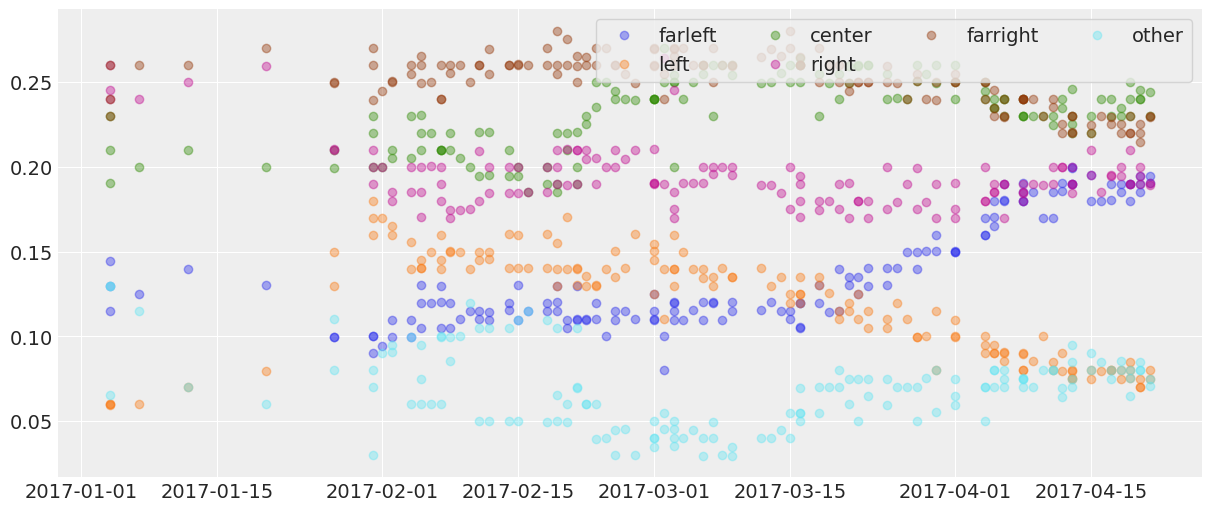

In [5]:
(
    polls_train,
    polls_test,
    results,
    observed_days_id,
    estimated_days,
    pollster_id,
    COORDS,
) = set_data_and_coords(
    election_date=ELECTION_DAY,
    parties_complete=PARTIES_COMPLETE,
    test_cutoff=TEST_CUTOFF,
)

## GP approximation

In [8]:
GP_CONFIG = {
    "lengthscale": [7, 17, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
}

In [9]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal("intercept", sigma=0.5, dims="parties_complete")
    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.5,
        dims=("pollsters", "parties_complete"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept")
    shrinkage = pm.HalfNormal("shrinkage", 0.5)
    raw_lsd = ZeroSumNormal("raw_lsd_party", dims="parties_complete")
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept + shrinkage * raw_lsd),
        dims="parties_complete",
    )
    # shrinkage = pm.HalfNormal("shrinkage", 0.5)
    # sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")

    # Estimate cov btw parties
    # chol, corr, stds = pm.LKJCholeskyCov(
    #   "chol",
    #  n=len(COORDS["parties_complete"]),
    # eta=5.0,
    # sd_dist=pm.HalfNormal.dist(shrinkage),
    # compute_corr=True,
    # )
    #    pm.Deterministic("time_weight", stds, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=estimated_days, gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, :],
        dims=(gp_basis_dim, "parties_complete"),
        zerosum_axes=-1,
    )

    #    gps = pm.Deterministic(
    #       "time_effect",
    #      aet.dot(gp_basis_funcs, aet.tensordot(chol, raw_coefs, axes=(1, 1)).T),
    #     dims=("estimated_days", "parties_complete"),
    # )
    gps = pm.Deterministic(
        "time_effect",
        aet.dot(gp_basis_funcs, raw_coefs),
        dims=("estimated_days", "parties_complete"),
    )

    # data
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    observed_days_idx = pm.Data(
        "observed_days_idx", observed_days_id, dims="observations"
    )
    observed_N = pm.Data(
        "observed_N", polls_train["samplesize"].values, dims="observations"
    )
    observed_polls = pm.Data(
        "observed_polls",
        polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            intercept + house_effects[pollster_idx] + gps[observed_days_idx]
        ),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )

    # sampling
    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata = pm.sample(draws=2000, return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata.extend(arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, raw_lsd_party, shrinkage, lsd_intercept, house_effects, intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 161 seconds.


0, dim: observations, 54 =? 54
1, dim: parties_complete, 1 =? 6


The number of effective samples is smaller than 10% for some parameters.


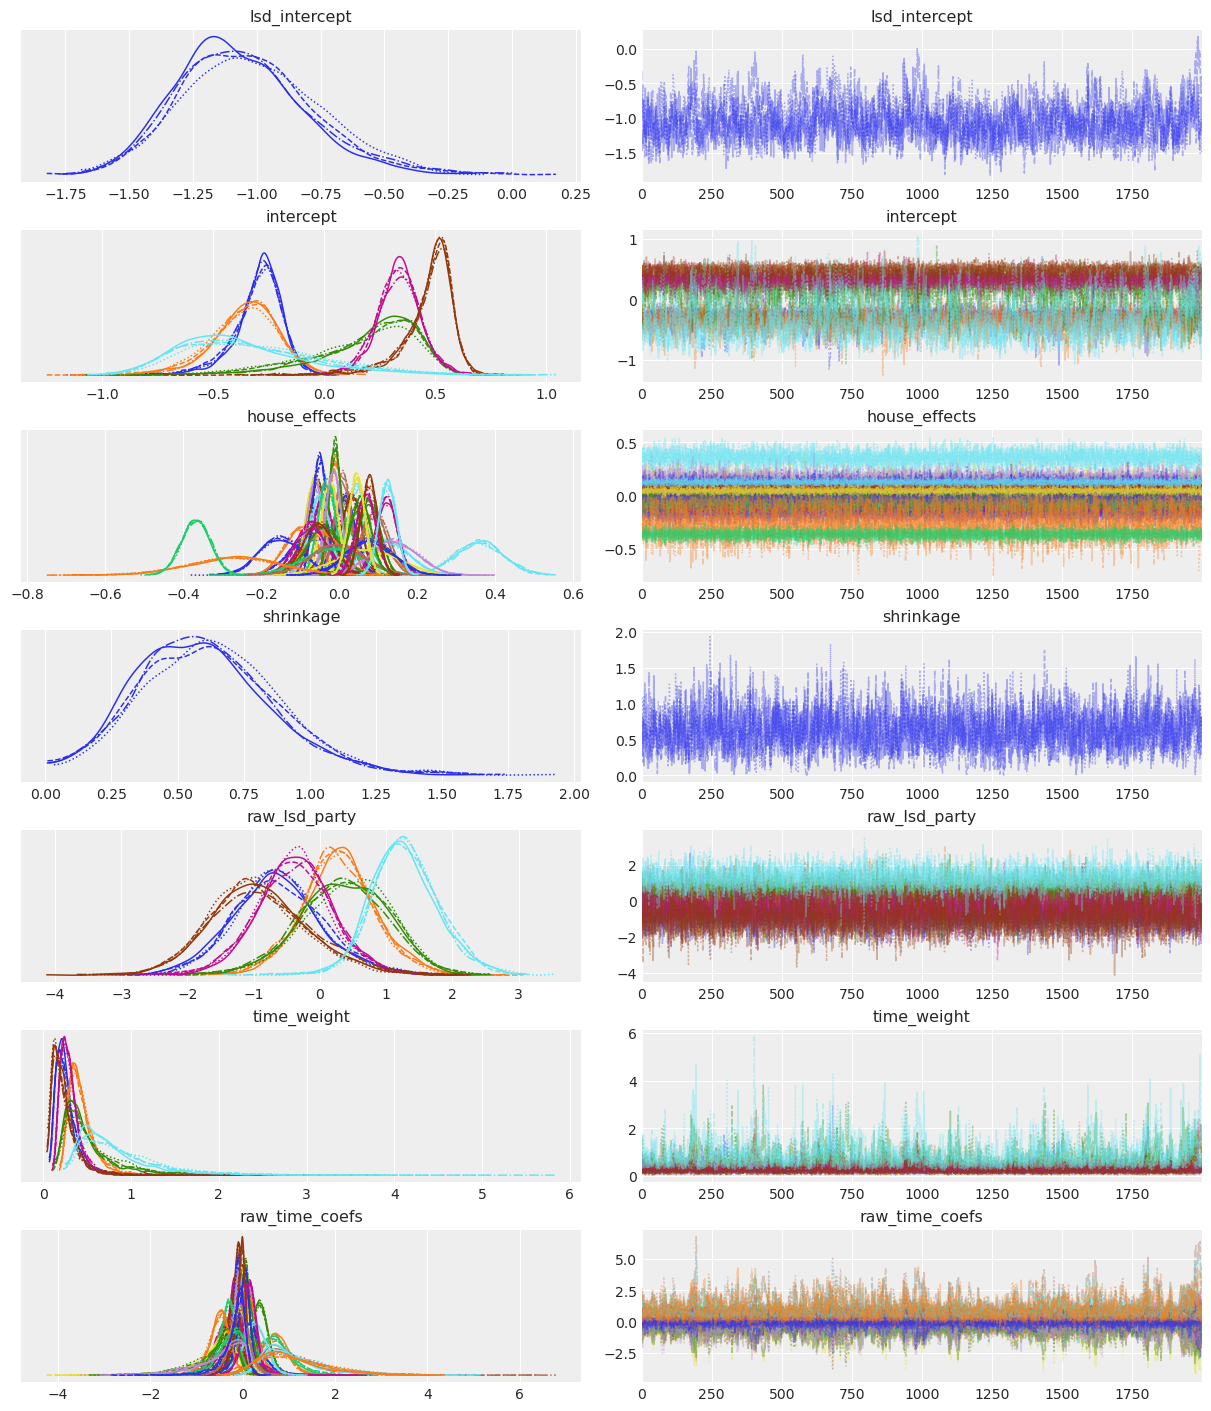

In [10]:
arviz.plot_trace(idata, var_names=["~time_effect", "~popularity"]);

In [11]:
summary = arviz.summary(
    idata,
    kind="diagnostics",
)

In [12]:
summary[summary["ess_bulk"] <= 800]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lsd_intercept,0.011,0.008,630.0,931.0,1.01
intercept[5],0.013,0.009,609.0,1084.0,1.01
time_weight[5],0.021,0.015,595.0,1034.0,1.01
"raw_time_coefs[1,5]",0.020,0.014,679.0,731.0,1.01
"raw_time_coefs[4,5]",0.036,0.026,595.0,645.0,1.01
...,...,...,...,...,...
"time_effect[105,5]",0.042,0.031,606.0,783.0,1.01
"time_effect[106,5]",0.041,0.030,620.0,779.0,1.01
"time_effect[107,5]",0.040,0.029,633.0,806.0,1.01
"time_effect[108,5]",0.038,0.028,644.0,840.0,1.01


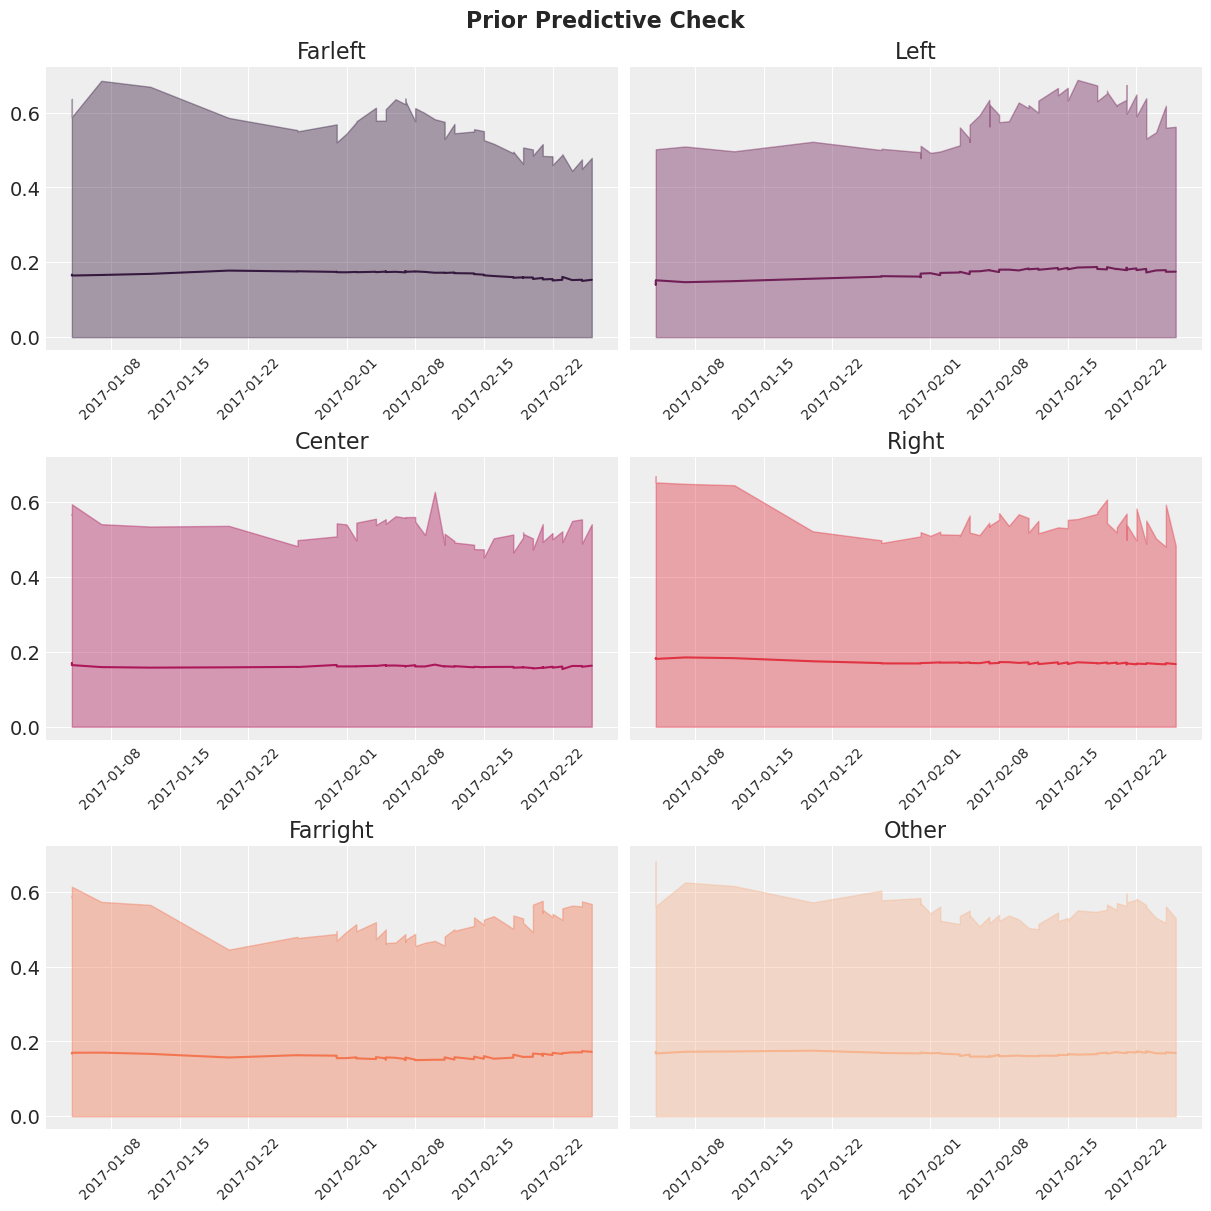

In [13]:
retrodictive_plot(idata, PARTIES_COMPLETE, polls_train, group="prior")

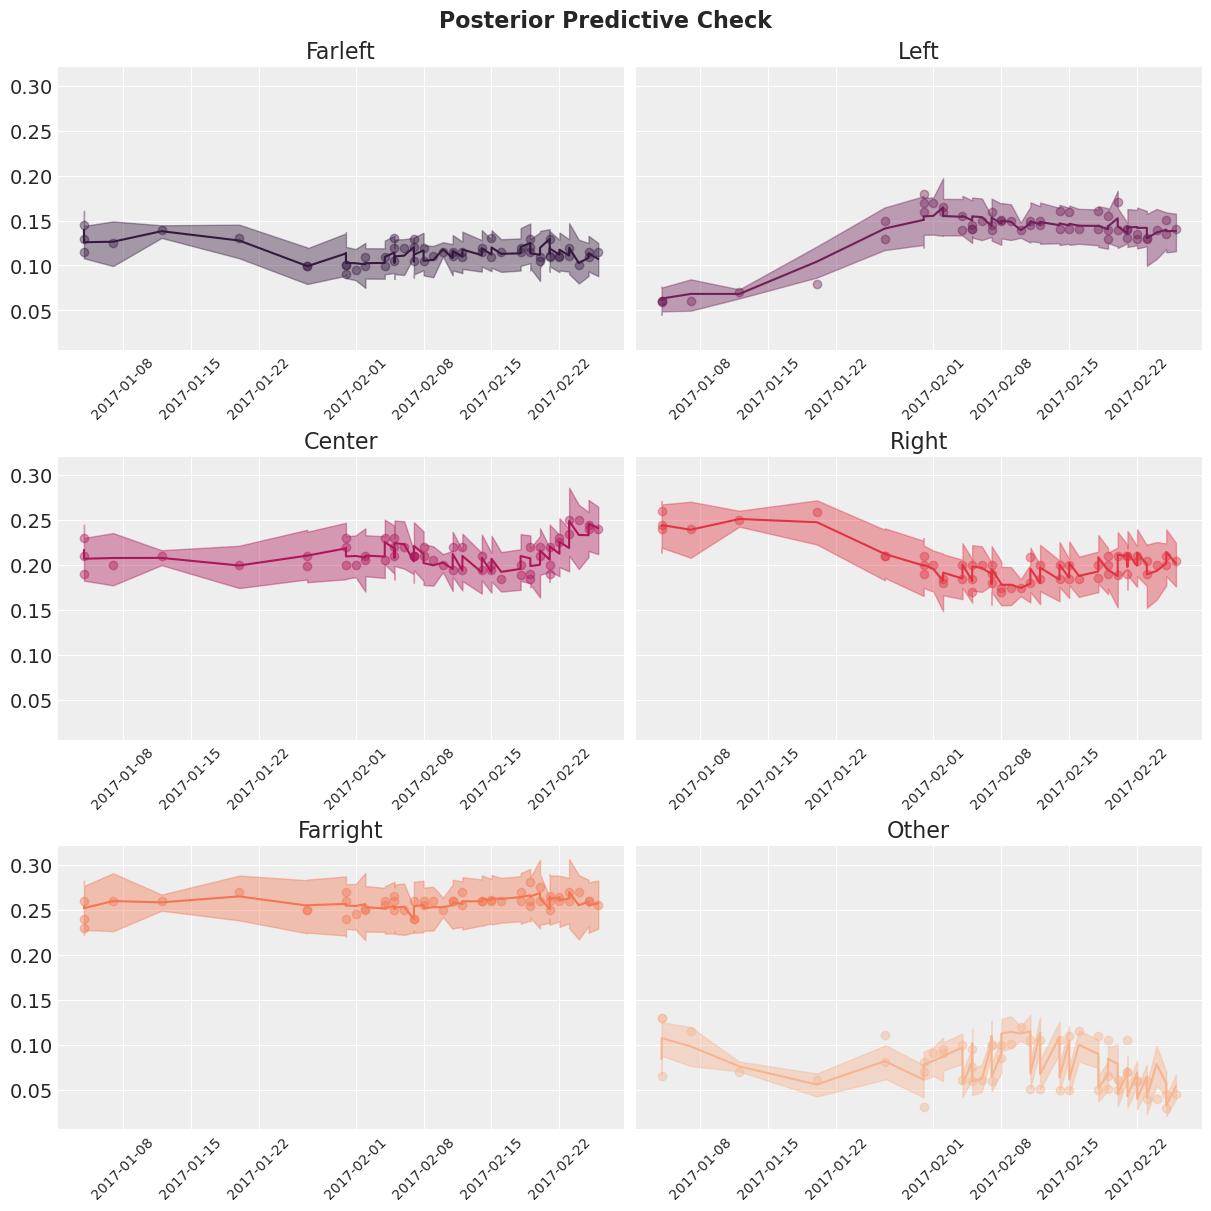

In [14]:
retrodictive_plot(idata, PARTIES_COMPLETE, polls_train)

In [15]:
with plain_mult:
    pm.set_data(
        {
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_days_idx": estimated_days,
            "observed_N": np.random.choice(
                polls_train["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),  # just a placeholder
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )

In [16]:
PREDICTION_COORDS = {
    "observations": idata.posterior["estimated_days"],
    "estimated_days": idata.posterior["estimated_days"],
}
PREDICTION_DIMS = {
    "time_effect": ["estimated_days", "parties_complete"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}
with plain_mult:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

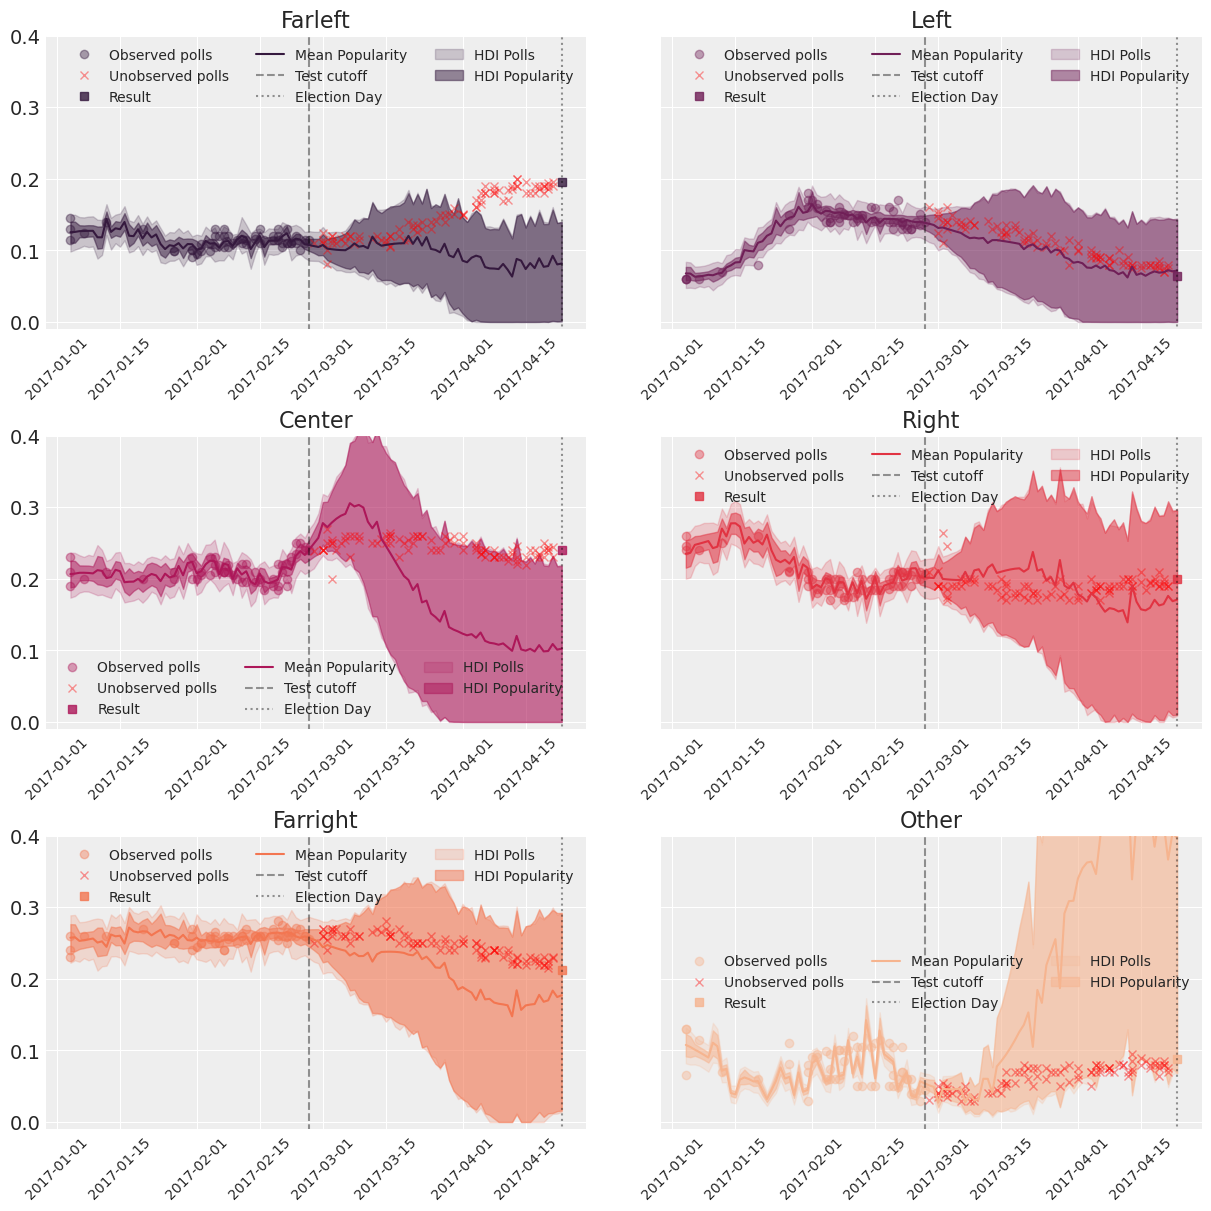

In [17]:
predictive_plot(
    idata, PARTIES_COMPLETE, polls_train, polls_test, results, ELECTION_DAY, TEST_CUTOFF
)
plt.savefig("multinom_ppc.png")

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -a "Alexandre Andorra & Rémi Louf"

Author: Alexandre Andorra & Rémi Louf

Last updated: Sat Sep 11 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

arviz     : 0.11.2
pymc3     : 3.11.2
matplotlib: 3.4.1
theano    : 1.1.2
pandas    : 1.2.4
numpy     : 1.20.2

